# Teeth Classification 

 It covers:

- Environment & dependencies
- Dataset inspection & visualization
- Preprocessing & augmentations (with a fast/light mode)
- From-scratch CNN (and a tiny variant for limited GPUs)
- Training with TensorBoard logging and periodic checkpoints
- Evaluation, confusion matrix, and misclassified examples



In [ ]:
import os
import random
import math
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, datasets

from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

print('Imports done')

Imports done


In [30]:
# Configuration & reproducibility (editable)
ROOT = Path('..')
DATA_DIR = ROOT / 'data' / 'Teeth_Dataset'
TRAIN_DIR = DATA_DIR / 'Training'
VAL_DIR = DATA_DIR / 'Validation'
TEST_DIR = DATA_DIR / 'Testing'

OUTPUT_DIR = ROOT / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Main hyperparams 
NUM_CLASSES = 7
IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For checkpointing and tensorboard
SAVE_EVERY = 2  # save a checkpoint every N epochs
TB_LOG_DIR = OUTPUT_DIR / 'runs'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print('Device:', DEVICE)
print('PyTorch:', torch.__version__)
print('ROOT folder:', ROOT.resolve())

Device: cuda
PyTorch: 2.5.1+cu121
ROOT folder: C:\Users\Eng.Razan\Documents\Cellula Projects


## GPU memory check & recommended batch size
This cell checks the GPU memory and prints a conservative recommended batch size.


In [6]:
def recommend_batch_size(img_size=IMG_SIZE, safety_factor=0.7, base_per_image_gb=0.12):
    """
    Heuristic recommendation for batch size based on GPU memory.
    - base_per_image_gb: rough GB per image including activations/gradients for a moderate model at 224x224 (default 0.12 GB ~120MB)
    - safety_factor: fraction of total GPU memory we'll use to leave room for others (0.7 default)
    Returns (total_mem_gb, recommended_batch)
    """
    if not torch.cuda.is_available():
        return 0.0, 4
    prop = torch.cuda.get_device_properties(0)
    total_mem_gb = prop.total_memory / (1024**3)
    # scale base per image with image area relative to 224
    scale = (img_size / 224) ** 2
    per_image = base_per_image_gb * scale
    avail = total_mem_gb * safety_factor
    rec = int(avail / per_image)
    rec = max(4, min(rec, 256))
    return total_mem_gb, rec

total_mem_gb, rec_bs = recommend_batch_size()
print(f'Total GPU memory (GB): {total_mem_gb:.2f}')
print(f'Recommended starting batch size (heuristic): {rec_bs}')
print('Note: This is an estimate. Monitor actual GPU memory (nvidia-smi) and lower batch size if CUDA OOM occurs.')

Total GPU memory (GB): 4.00
Recommended starting batch size (heuristic): 23
Note: This is an estimate. Monitor actual GPU memory (nvidia-smi) and lower batch size if CUDA OOM occurs.


## Dataset quick inspection
This cell will count images per class for Training / Validation / Testing and show a bar plot of the training distribution.

Train class counts: OrderedDict([('CaS', 480), ('CoS', 450), ('Gum', 360), ('MC', 540), ('OC', 324), ('OLP', 540), ('OT', 393)])
Val class counts: OrderedDict([('CaS', 160), ('CoS', 149), ('Gum', 120), ('MC', 180), ('OC', 108), ('OLP', 180), ('OT', 131)])
Test class counts (only class folders): OrderedDict([('CaS', 160), ('CoS', 149), ('Gum', 120), ('MC', 180), ('OC', 108), ('OLP', 180), ('OT', 131), ('out', 160), ('output', 160), ('outputs', 160)])


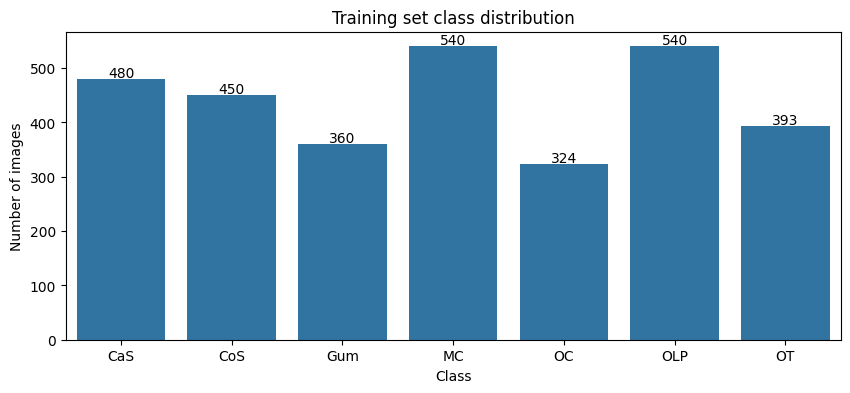

In [3]:
from collections import OrderedDict

def get_class_counts(folder: Path):
    classes = OrderedDict()
    if not folder.exists():
        print(f'Folder {folder} does not exist — check DATA_DIR')
        return classes
    for cls in sorted([p for p in folder.iterdir() if p.is_dir()]):
        classes[cls.name] = sum(1 for _ in cls.rglob('*') if _.suffix.lower() in ['.jpg','.jpeg','.png','.bmp'])
    return classes

train_counts = get_class_counts(TRAIN_DIR)
val_counts = get_class_counts(VAL_DIR)
test_counts = get_class_counts(TEST_DIR)

print('Train class counts:', train_counts)
print('Val class counts:', val_counts)
print('Test class counts (only class folders):', test_counts)

# plot
if train_counts:
    names = list(train_counts.keys())
    vals = [train_counts[n] for n in names]
    plt.figure(figsize=(10,4))
    sns.barplot(x=names, y=vals)
    plt.title('Training set class distribution')
    plt.ylabel('Number of images')
    plt.xlabel('Class')
    for i,v in enumerate(vals):
        plt.text(i, v+3, str(v), ha='center')
    plt.show()


## Visual examples — samples per class
Shows a small grid of raw images (unaugmented) per class.

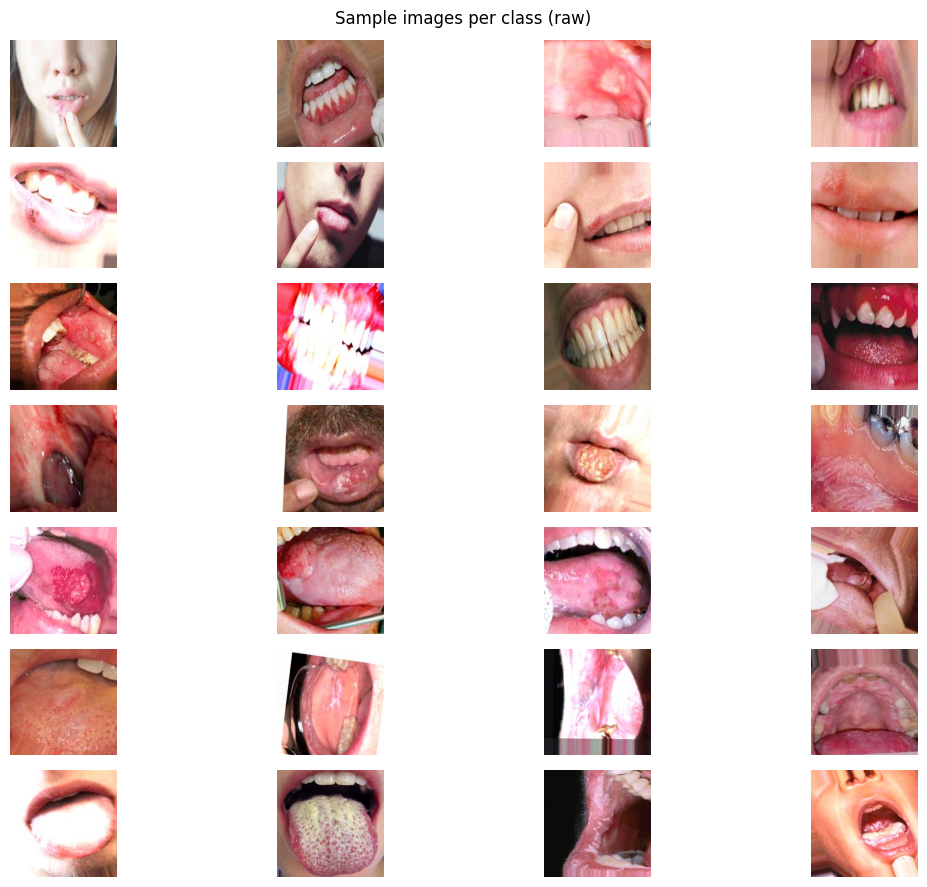

In [8]:
def show_samples_per_class(root_dir, classes=None, n=4, figsize=(12,9)):
    root = Path(root_dir)
    classes = classes or sorted([p.name for p in root.iterdir() if p.is_dir()])
    fig, axes = plt.subplots(len(classes), n, figsize=figsize)
    for i, cls in enumerate(classes):
        cls_dir = root / cls
        imgs = list(cls_dir.glob('*'))
        imgs = [p for p in imgs if p.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]
        random.shuffle(imgs)
        for j in range(n):
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            if j < len(imgs):
                img = Image.open(imgs[j]).convert('RGB')
                ax.imshow(img)
            ax.axis('off')
        axes[i,0].set_ylabel(cls, fontsize=11)
    plt.suptitle('Sample images per class (raw)')
    plt.tight_layout()
    plt.show()

if train_counts:
    show_samples_per_class(TRAIN_DIR, n=4)
else:
    print('No training images found — check the dataset path.')

## Preprocessing & Augmentation
We compute dataset mean/std (sample-based) and define two transform pipelines:
- train_transforms: stronger augmentations
- val_transforms: deterministic center-crop

A 'fast' mode is provided below to reduce image size and augmentations for quick experiments.

In [4]:
def compute_mean_std(root_dir, sample_size=400):
    imgs = []
    for cls in sorted([p for p in Path(root_dir).iterdir() if p.is_dir()]):
        imgs += [p for p in cls.glob('*') if p.suffix.lower() in ['.jpg','.jpeg','.png']]
    random.shuffle(imgs)
    imgs = imgs[:sample_size]
    means = []
    stds = []
    for p in tqdm(imgs, desc='Computing mean/std'):
        im = Image.open(p).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        arr = np.array(im).astype(np.float32)/255.0
        means.append(arr.mean(axis=(0,1)))
        stds.append(arr.std(axis=(0,1)))
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)
    return mean.tolist(), std.tolist()

try:
    mean, std = compute_mean_std(TRAIN_DIR, sample_size=400)
except Exception as e:
    print('Failed to compute mean/std — falling back to ImageNet values', e)
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

print('Using mean:', mean)
print('Using std:', std)

# Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.15,0.05)], p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Fast-mode options
FAST = False  # set True to enable fast/light mode
if FAST:
    IMG_SIZE = 160
    BATCH_SIZE = max(8, BATCH_SIZE//2)
    print('FAST mode enabled: IMG_SIZE set to', IMG_SIZE, 'BATCH_SIZE set to', BATCH_SIZE)

# Denormalize helper for visualization
def denormalize(tensor_img):
    img = tensor_img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(img, 0, 1)

print('Transforms ready')

Computing mean/std: 100%|██████████| 400/400 [00:01<00:00, 315.52it/s]

Using mean: [0.736379086971283, 0.5023845434188843, 0.47808578610420227]
Using std: [0.18056179583072662, 0.20397624373435974, 0.19781821966171265]
Transforms ready


### Before and after augmentation — visual check
Run this to inspect how augmentations change samples. Useful to ensure augmentations don't break the diagnostically relevant features.

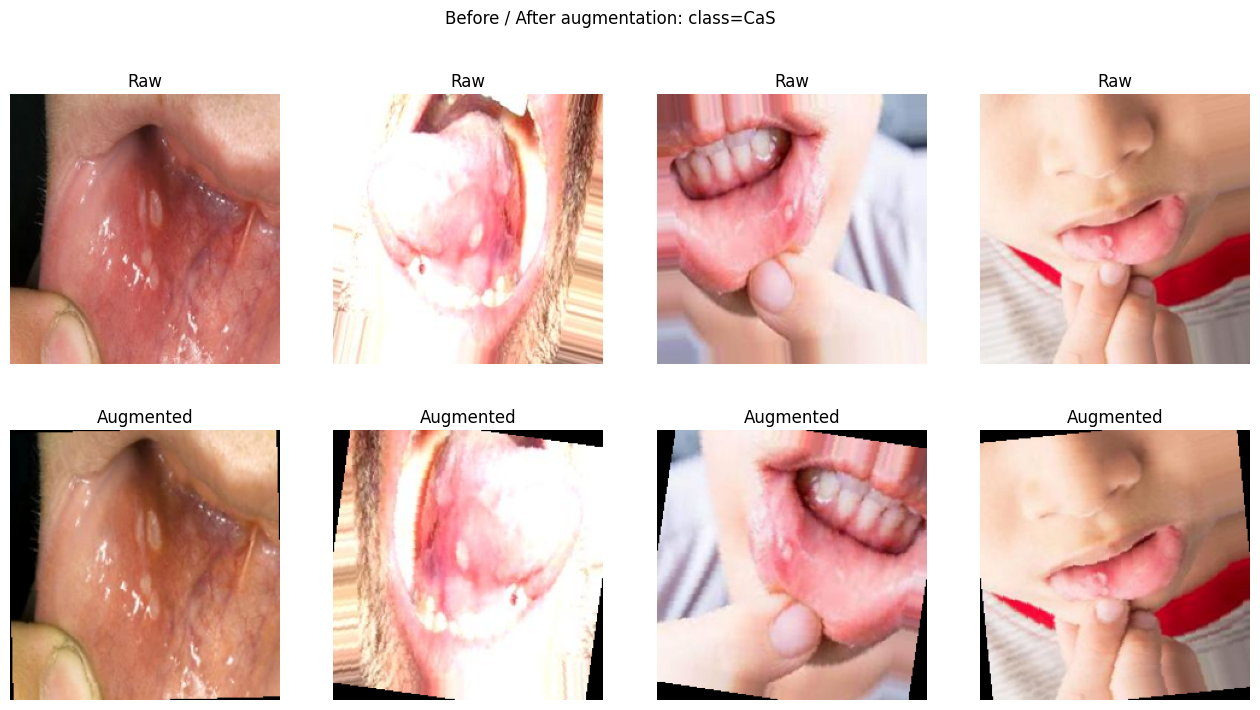

In [10]:
def show_before_after(root_dir, cls, n=4):
    cls_dir = Path(root_dir)/cls
    imgs = [p for p in cls_dir.glob('*') if p.suffix.lower() in ['.jpg','jpeg','png']]
    random.shuffle(imgs)
    samples = imgs[:n]
    fig, axes = plt.subplots(2, n, figsize=(4*n,8))
    for i,p in enumerate(samples):
        raw = Image.open(p).convert('RGB').resize((IMG_SIZE,IMG_SIZE))
        axes[0,i].imshow(raw); axes[0,i].axis('off'); axes[0,i].set_title('Raw')
        aug = train_transforms(raw)
        aug = denormalize(aug)
        axes[1,i].imshow(np.transpose(aug.numpy(), (1,2,0))); axes[1,i].axis('off'); axes[1,i].set_title('Augmented')
    plt.suptitle(f'Before / After augmentation: class={cls}')
    plt.show()

if train_counts:
    some_class = list(train_counts.keys())[0]
    show_before_after(TRAIN_DIR, some_class, n=4)


## Datasets and DataLoaders
We use `ImageFolder`. To mitigate class imbalance we provide both options:
- Oversampling via `WeightedRandomSampler` (used by default)
- Using class weights in the loss function (optional)


In [5]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

class_names = train_dataset.classes
print('Class names:', class_names)

train_targets = [y for _,y in train_dataset.samples]
class_sample_counts = np.array([train_targets.count(i) for i in range(len(class_names))])
print('Per-class counts:', class_sample_counts)

weights = 1. / class_sample_counts
samples_weights = np.array([weights[t] for t in train_targets])
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print('Train loader batches:', len(train_loader))

# class weights option for loss
class_weights = torch.tensor([1.0/count for count in class_sample_counts], dtype=torch.float32).to(DEVICE)
print('Class weights (use with CrossEntropyLoss):', class_weights)


Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Per-class counts: [480 450 360 540 324 540 393]
Train loader batches: 97
Class weights (use with CrossEntropyLoss): tensor([0.0021, 0.0022, 0.0028, 0.0019, 0.0031, 0.0019, 0.0025],
       device='cuda:0')


## Model (from-scratch)
We provide a moderate SmallCNN for good capacity and a `TinyCNN` option for very limited GPUs / faster experimentation. Both are *from scratch* (no pretrained backbones).

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class SmallCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.05),

            ConvBlock(32, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.08),

            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),

            ConvBlock(128, 256),
            ConvBlock(256, 256),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class TinyCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 16),
            nn.MaxPool2d(2),
            ConvBlock(16, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Choose model variant
MODEL_VARIANT = 'small'  # change to 'tiny' for faster runs
if MODEL_VARIANT == 'small':
    model = SmallCNN(num_classes=NUM_CLASSES).to(DEVICE)
else:
    model = TinyCNN(num_classes=NUM_CLASSES).to(DEVICE)

print('Model variant:', MODEL_VARIANT)
print(model)
print('Trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))


Model variant: small
SmallCNN(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.05, inplace=False)
    (4): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (5): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

## Training utilities: optimizer, loss, TensorBoard logging, checkpointing
This cell sets up `CrossEntropyLoss` (with class weights optional), the optimizer, LR scheduler, `SummaryWriter` for TensorBoard, mixed precision scaler, and utility functions for train/validate. Checkpoints are saved every `SAVE_EVERY` epochs and best model is saved separately.

In [11]:
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# TensorBoard writer
writer = SummaryWriter(log_dir=str(TB_LOG_DIR))
print('TensorBoard logs in', TB_LOG_DIR)

# AMP scaler
scaler = torch.cuda.amp.GradScaler()

# training and validation functions

def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            out = model(xb)
            loss = criterion(out, yb)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    return running_loss / total, correct / total, all_preds, all_targets

print('Training utilities ready')


TensorBoard logs in ..\outputs\runs
Training utilities ready


c:\Users\Eng.Razan\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Eng.Razan\AppData\Local\Temp\ipykernel_19424\3839476103.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## Training loop
Runs full training with TensorBoard logging and periodic checkpoints. You can interrupt and resume later by loading a checkpoint.

Epoch 1/30


C:\Users\Eng.Razan\AppData\Local\Temp\ipykernel_16272\3839476103.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


  Train loss: 1.8230 | Train acc: 0.2660
  Val   loss: 1.7474 | Val   acc: 0.2743
  Saved new best model
Epoch 2/30
  Train loss: 1.7101 | Train acc: 0.3103
  Val   loss: 1.7581 | Val   acc: 0.2860
  Saved new best model
  Saved checkpoint to ..\outputs\ckpt_epoch_2.pth
Epoch 3/30
  Train loss: 1.6619 | Train acc: 0.3259
  Val   loss: 1.7265 | Val   acc: 0.3006
  Saved new best model
Epoch 4/30
  Train loss: 1.6234 | Train acc: 0.3482
  Val   loss: 1.5716 | Val   acc: 0.3463
  Saved new best model
  Saved checkpoint to ..\outputs\ckpt_epoch_4.pth
Epoch 5/30
  Train loss: 1.5576 | Train acc: 0.3696
  Val   loss: 1.5555 | Val   acc: 0.3434
Epoch 6/30
  Train loss: 1.5433 | Train acc: 0.3732
  Val   loss: 1.4620 | Val   acc: 0.4173
  Saved new best model
  Saved checkpoint to ..\outputs\ckpt_epoch_6.pth
Epoch 7/30
  Train loss: 1.4836 | Train acc: 0.4007
  Val   loss: 1.4505 | Val   acc: 0.4290
  Saved new best model
Epoch 8/30
  Train loss: 1.4788 | Train acc: 0.4049
  Val   loss: 1.4796

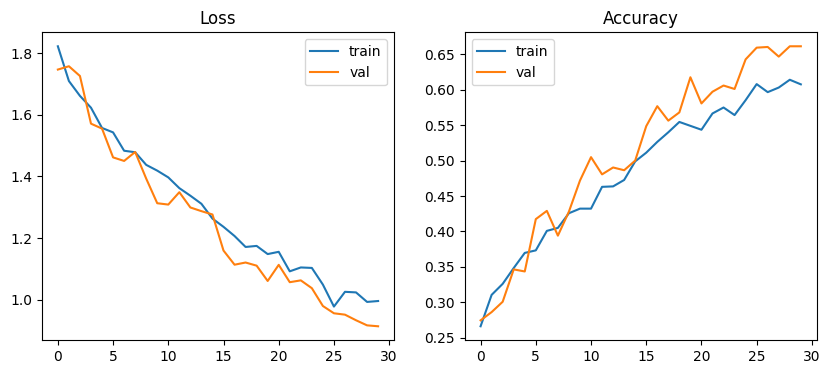

Training completed (or stopped). Artifacts written to ..\outputs


In [14]:
best_val_acc = 0.0
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
start_epoch = 1

# Optional: resume from checkpoint (set path to a .pth file)
RESUME_PATH = None  # e.g., OUTPUT_DIR/'ckpt_epoch_4.pth'
if RESUME_PATH is not None:
    ck = torch.load(RESUME_PATH, map_location=DEVICE)
    model.load_state_dict(ck['model_state_dict'])
    optimizer.load_state_dict(ck['optimizer_state_dict'])
    start_epoch = ck.get('epoch', 1) + 1
    best_val_acc = ck.get('best_val_acc', 0.0)
    print('Resumed from', RESUME_PATH, 'starting at epoch', start_epoch)

for epoch in range(start_epoch, NUM_EPOCHS+1):
    print(f'Epoch {epoch}/{NUM_EPOCHS}')
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, scaler=scaler)
    val_loss, val_acc, val_preds, val_targets = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # TensorBoard logging
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/val', val_acc, epoch)

    print(f'  Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}')
    print(f'  Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}')

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state_dict': model.state_dict(), 'class_names': class_names, 'epoch': epoch}, OUTPUT_DIR/'best_model.pth')
        print('  Saved new best model')

    # periodic checkpoint
    if epoch % SAVE_EVERY == 0:
        ckpt_path = OUTPUT_DIR / f'ckpt_epoch_{epoch}.pth'
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch': epoch, 'best_val_acc': best_val_acc}, ckpt_path)
        print('  Saved checkpoint to', ckpt_path)

# finalize
writer.flush()
writer.close()

# plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title('Loss'); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title('Accuracy'); plt.legend()
plt.show()

# Save history
with open(OUTPUT_DIR / 'history.json', 'w') as f:
    json.dump(history, f)

print('Training completed (or stopped). Artifacts written to', OUTPUT_DIR)


In [13]:
# --- Cell A: Filter & remap Testing -> use only classes present in training set ---
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Allowed classes from training
allowed_classes = set(train_dataset.classes)
train_class_to_idx = train_dataset.class_to_idx

# Extensions to consider
exts = {'.jpg', '.jpeg', '.png', '.bmp'}

test_root = Path(TEST_DIR)

filtered_samples = []
excluded_folders = set()

# Walk test directory and keep only images whose parent folder is in training classes
for p in test_root.rglob('*'):
    if p.suffix.lower() in exts and p.is_file():
        parent = p.parent.name
        if parent in allowed_classes:
            # map to training label index to guarantee alignment
            filtered_samples.append((str(p), train_class_to_idx[parent]))
        else:
            excluded_folders.add(parent)

print(f"Raw test images found (according to ImageFolder): {len(test_dataset.samples)}")
print(f"Test images after filtering to train classes: {len(filtered_samples)}")
if excluded_folders:
    print("Excluded non-class folders found in Testing (examples):", list(excluded_folders)[:10])

# Define a simple dataset that uses the same val_transforms for preprocessing
class FilteredImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# Create filtered dataset + loader (same batch settings as before)
test_dataset_filtered = FilteredImageDataset(filtered_samples, transform=val_transforms)
test_loader_filtered =DataLoader(test_dataset_filtered, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         num_workers=0,
                         pin_memory=True)
print("Rebuilt test_loader with num_workers=0, samples:", len(test_loader.dataset))

# Replace test_loader variable so remaining cells use the filtered loader
test_loader = test_loader_filtered

# Quick sanity checks
if len(test_dataset_filtered) == 0:
    raise RuntimeError("Filtered test set has 0 samples — check your TEST_DIR structure or training class names.")
else:
    labels = [lbl for _, lbl in test_dataset_filtered.samples]
    print("Filtered test labels min/max:", min(labels), max(labels))
    print("Valid label range should be 0..", len(train_dataset.classes)-1)


Raw test images found (according to ImageFolder): 1508
Test images after filtering to train classes: 1028
Excluded non-class folders found in Testing (examples): ['outputs', 'out', 'output', 'Testing']
Rebuilt test_loader with num_workers=0, samples: 1028
Filtered test labels min/max: 0 6
Valid label range should be 0.. 6


In [9]:
# === Safe load checkpoint (load on CPU, then move model to DEVICE) ===
import torch
from pathlib import Path

ckpt_path = Path('../outputs') / 'best_model.pth'   # adjust if different
print("Safe-loading checkpoint from:", ckpt_path)

# Load all tensors onto CPU to avoid GPU deserialization issues
ckpt = torch.load(ckpt_path, map_location='cpu')
print("Checkpoint keys:", list(ckpt.keys()))

# model must already be instantiated (run the Model cell above)
model.load_state_dict(ckpt['model_state_dict'])
# now move model to GPU (if available)
model.to(DEVICE)
model.eval()
print("Model loaded and moved to", DEVICE)


Safe-loading checkpoint from: ..\outputs\best_model.pth
Checkpoint keys: ['model_state_dict', 'class_names', 'epoch']
Model loaded and moved to cuda


C:\Users\Eng.Razan\AppData\Local\Temp\ipykernel_19424\1980692344.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')


## Evaluation on test set
Loads best model and evaluates on test set, prints classification report and confusion matrix.

Loading checkpoint from: ..\outputs\best_model.pth
Checkpoint keys: ['model_state_dict', 'class_names', 'epoch']
Model loaded and moved to cuda


C:\Users\Eng.Razan\AppData\Local\Temp\ipykernel_19424\297472613.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')


Test loss: 0.8945 | Test acc: 0.6605


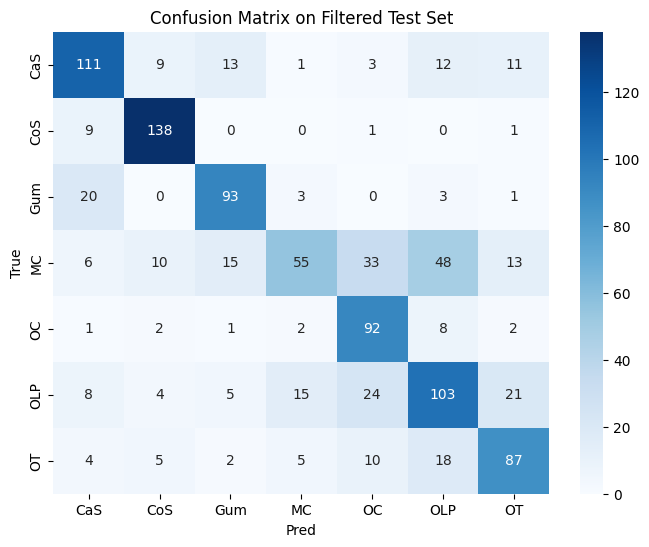


Classification Report:
              precision    recall  f1-score   support

         CaS     0.6981    0.6937    0.6959       160
         CoS     0.8214    0.9262    0.8707       149
         Gum     0.7209    0.7750    0.7470       120
          MC     0.6790    0.3056    0.4215       180
          OC     0.5644    0.8519    0.6790       108
         OLP     0.5365    0.5722    0.5538       180
          OT     0.6397    0.6641    0.6517       131

    accuracy                         0.6605      1028
   macro avg     0.6657    0.6841    0.6599      1028
weighted avg     0.6655    0.6605    0.6468      1028



In [14]:
# --- Final Evaluation on filtered test loader ---

# 1) Load checkpoint safely (CPU first, then move to GPU)
ckpt_path = OUTPUT_DIR / 'best_model.pth'
print("Loading checkpoint from:", ckpt_path)

ckpt = torch.load(ckpt_path, map_location='cpu')
print("Checkpoint keys:", list(ckpt.keys()))

# model must already be instantiated
model.load_state_dict(ckpt['model_state_dict'])
model.to(DEVICE)
model.eval()
print("Model loaded and moved to", DEVICE)

# 2) Run validation on filtered test loader
test_loss, test_acc, test_preds, test_targets = validate(model, test_loader, criterion, DEVICE)
print(f'Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

# 3) Confusion matrix and classification report
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            cmap='Blues')
plt.ylabel('True'); plt.xlabel('Pred'); plt.title('Confusion Matrix on Filtered Test Set')
plt.show()

print('\nClassification Report:')
print(classification_report(test_targets, test_preds, target_names=train_dataset.classes, digits=4))


## Visualize misclassified examples
Randomly shows some misclassified test samples for manual inspection.

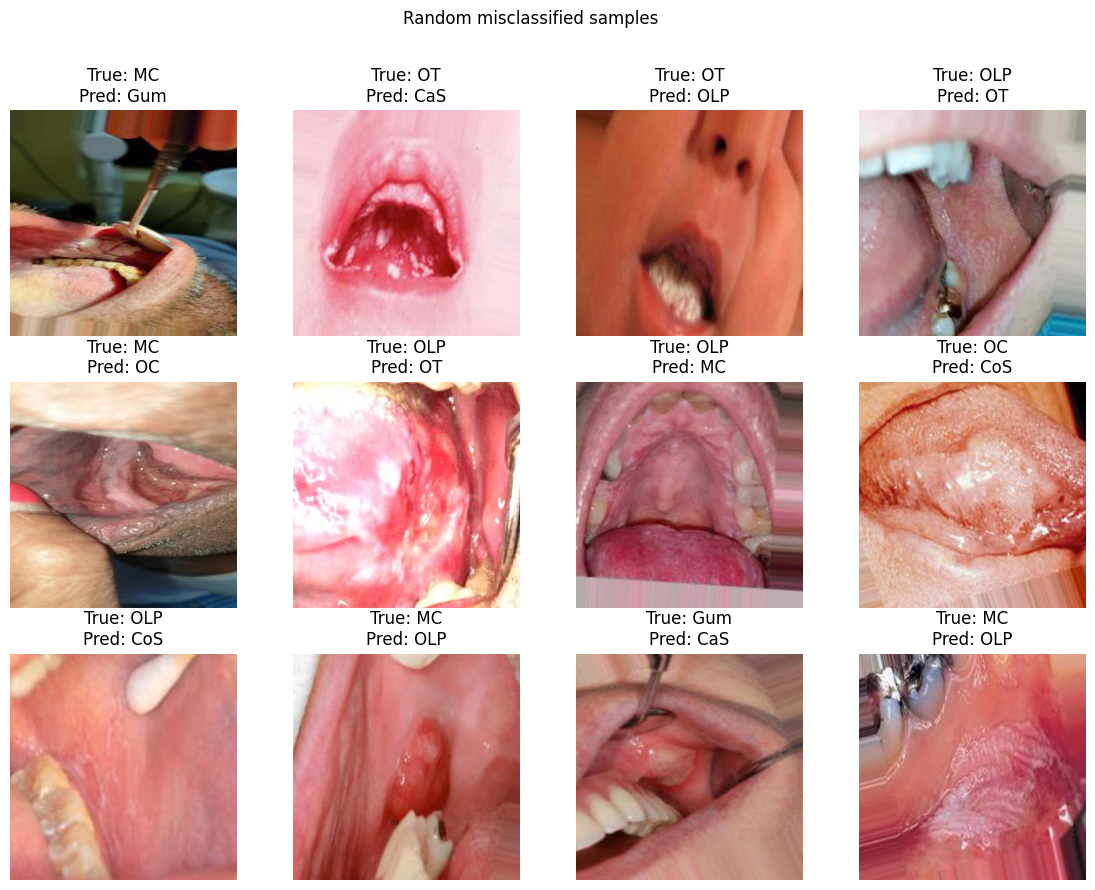

In [15]:
def show_misclassified(dataset, preds, targets, n=12):
    mis_idx = np.where(preds != targets)[0]
    if len(mis_idx) == 0:
        print('No misclassifications')
        return
    sel = np.random.choice(mis_idx, size=min(n, len(mis_idx)), replace=False)
    plt.figure(figsize=(14,10))
    for i, idx in enumerate(sel):
        path, _ = dataset.samples[idx]
        img = Image.open(path).convert('RGB')
        plt.subplot(3,4,i+1)
        plt.imshow(img); plt.axis('off')
        plt.title(f'True: {class_names[targets[idx]]}\nPred: {class_names[preds[idx]]}')
    plt.suptitle('Random misclassified samples')
    plt.show()

show_misclassified(test_dataset, test_preds, test_targets, n=12)


In [23]:
# Validation / test preprocessing using dataset stats
from torchvision import transforms

IMG_SIZE = 224  # same as training

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7363791, 0.50238454, 0.47808579],
                         std=[0.1805618, 0.20397624, 0.19781822])
])


## Optional: Grad-CAM 
Lightweight interpretability helper — uncomment and customize layer name if you want to visualize model attention.

In [24]:
#Grad-CAM helper 
def grad_cam(model, input_tensor, target_class=None, layer_name="features.13.conv"):
    model.eval()
    conv_layer = dict(model.named_modules())[layer_name]
    activation = None
    gradients = None
    def forward_hook(module, inp, outp):
        nonlocal activation
        activation = outp.detach()
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()
    h1 = conv_layer.register_forward_hook(forward_hook)
    h2 = conv_layer.register_backward_hook(backward_hook)
    out = model(input_tensor)
    if target_class is None:
        pred = out.argmax(dim=1).item()
    else:
        pred = target_class
    loss = out[0, pred]
    model.zero_grad(); loss.backward()
    weights = gradients.mean(dim=(2,3), keepdim=True)
    cam = (weights * activation).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
    cam = cam[0,0].cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    h1.remove(); h2.remove()
    return cam, pred



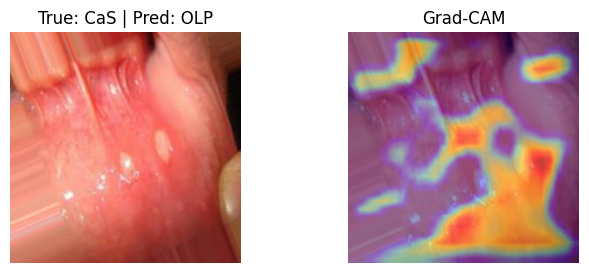

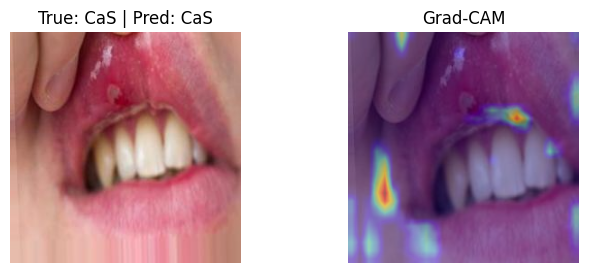

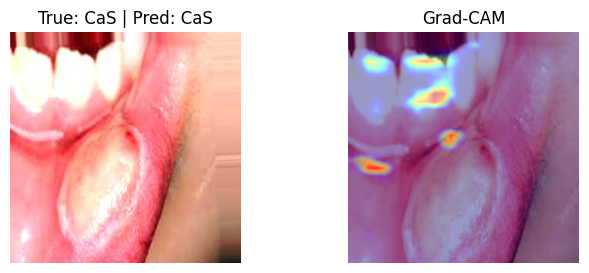

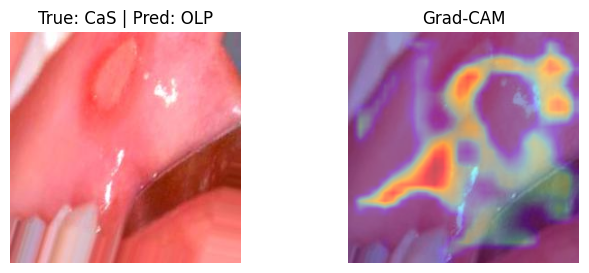

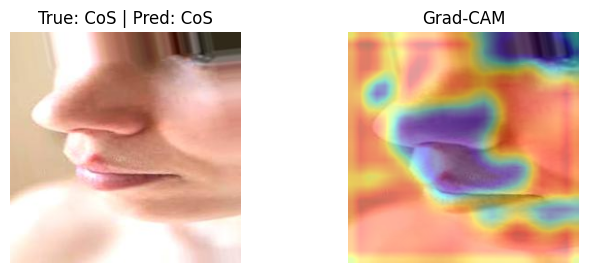

In [28]:
# --- Grad-CAM on multiple test samples ---
indices = [5, 20, 50, 100, 200]  # pick whichever indices you want

for idx in indices:
    img_path, label = test_dataset.samples[idx]
    raw_img = cv2.imread(img_path)[:,:,::-1]
    pil_img = Image.fromarray(raw_img)

    aug_img = val_transform(pil_img).unsqueeze(0).to(DEVICE)

    cam, pred_class = grad_cam(model, aug_img, layer_name="features.13.conv")
    pred_label = train_dataset.classes[pred_class]

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.imshow(raw_img)
    plt.title(f"True: {train_dataset.classes[label]} | Pred: {pred_label}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(raw_img)
    plt.imshow(cam, cmap="jet", alpha=0.4)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.show()


## Final notes & where artifacts are saved
- Best model: `outputs/best_model.pth`
- Periodic checkpoints: `outputs/ckpt_epoch_X.pth`
- TensorBoard logs: `outputs/runs/`
- Predictions & history: `outputs/` (history.json, test_preds.npy, test_targets.npy)

You can start TensorBoard with: `tensorboard --logdir outputs/runs` and open the displayed URL in your browser.

In [29]:
# Save predictions & history (if present)
try:
    np.save(OUTPUT_DIR / 'test_preds.npy', test_preds)
    np.save(OUTPUT_DIR / 'test_targets.npy', test_targets)
    print('Saved test predictions to', OUTPUT_DIR)
except Exception:
    print('No predictions to save (run evaluation first)')

try:
    with open(OUTPUT_DIR / 'history.json', 'w') as f:
        json.dump(history, f)
    print('Saved history.json')
except Exception:
    print('History not found (run training first)')


Saved test predictions to ..\outputs
History not found (run training first)
